
# When will my next purchase be?

We all grow up somehow believing in superheroes, don't we? When I was a kid I wish I could talk to animals so I would figure out a way to help them. However, others dreamt of flying, read people’s minds or even predict the future.

Humans are closer to achieving some of these dreams  (not talking to animals... Yet) using AI. One of these, of course, predicting the future. Would you imagine predicting how much you will sell the next week/month/year? 

And even though there are some complex applications on this problem outside, we will follow the simplest but accurate approach to this problem in the following repository. Enjoy!


## Background

So the owner of the data in question is a small supplier in a huge industry of healthcare goods. That is a Business to Business model. So as with every single company, they get a monthly closing sales file.

Fortunately ( at least for me) the firm owns a data warehouse so it was a matter of a couple of SQL sentences to fetch the data. I started to make queries and start exploring the data.

## Exploratory analysis

I was working with the same data for months. I designed and built the whole relational Data Model. That is why I focused the analysis on the main features of the data because I already knew the main insights from it.

On the first hand, I found out there were clients with a huge amount of purchases during the history. I picked the biggest one and I performed a Time Series analysis. For the record, columns Month and Q contain the date of the purchase and the amount of each product respectively.

First, some imports...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller
import os
path = 'some_path'
os.chdir(path)
%matplotlib inline 

Then, I read the sales file and parsed the dates.

In [ ]:
df = pd.read_csv(path + 'sales.csv')
dataset = df.copy()
df_1 = dataset.loc[:,['Month', 'Q']]
df_1.set_index('Month', inplace = True)
df_1.fillna(0, inplace = True)

Now it is time to plot sales in terms of Q. I calculated the moving average and a rolling standard devation in a time window of 6 months. Then I performed an ADCF test to check on Stationarity.

In [ ]:
plt.plot(df_1)
plt.xlabel('mes')
plt.ylabel('VentaUnd')
#Calculating MA and stdMA
rolmean = df_1.rolling(6).mean()#6 month time window
rolstd = df_1.rolling(6).std()#6 month time window
print(rolmean, rolstd)
#plotting MA and stdMA
plt.plot(df_1, c = 'b', label = 'Orginal')
plt.plot(rolmean, c = 'r', label = 'MA')
plt.plot(rolstd, c = 'g', label = 'stdMA')
plt.legend()
plt.title('Rolling test')
#Test restults
print("results ----> ")
dftest = adfuller(df_1.VentaUnd, autolag='AIC')#Akaike Information Criterion to deal with optimal lags
dfoutput = pd.Series(dftest[:4], index = ['Test Statistic', 'p-value',
                                          '#lags used', 'Number of observations Used'])
for elements in dftest[4].items():
    dfoutput['critical value ({})'.format(elements)] = elements
dfoutput

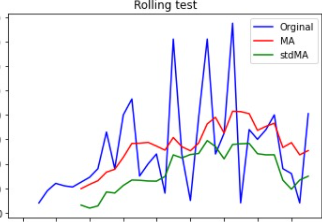
The plot looked stationary but when I performed the ADCF test it was just the opposite. It turned out that we failed to reject the null hypothesis with a P-Value = 0.39 (when it comes to ADCF tests, the null hypothesis states the data is non-stationary).  The main takeaway from this analysis was that we need to make some transformations to the data for a continuous approach (hopefully in another repository).

# Feature Engineering
During this whole project, I had a lot of support from business experts. The CEO of the company attended every single meeting to give advice. I took 8 features to feed the model which included:
* - Smoothed purchase ratio
* - Stationarity
* - Last month behavior


I made the following SQL code to extract the whole information I needed:

SELECT T1.CodigoUnico

            , SUM(T1.Success) as Success
            , DATE_DIFF(DATE_SUB(CURRENT_DATE(),INTERVAL 2 MONTH),MIN(T1.Date), MONTH) AS Total
            , AVG(T1.Seasonality) AS Seasonality
            , CASE WHEN T2.last_month IS NULL THEN "0" ELSE last_month END AS last_month         
FROM (

            SELECT CodigoUnico
            , Mes
            , EXTRACT(YEAR FROM Date) AS YEAR
            , EXTRACT(MONTH FROM Date) AS MONTH
            , COUNT(DISTINCT(CodigoUnico)) AS Success  
            , STDDEV_SAMP(Q) AS Seasonality
            FROM `Sells`
            WHERE  NOT ClasifSegCliente = "CADENA"
            GROUP BY CodigoUnico
            , Date
            , YEAR
            , MONTH
            ORDER BY YEAR, MONTH
) AS T1


LEFT JOIN (


    SELECT  DISTINCT(CodigoUnico)
           , "1" AS last_month
    FROM `Sells`
    WHERE Mes = DATE(
        CONCAT(
            EXTRACT(
                YEAR FROM DATE_SUB(CURRENT_DATE(),INTERVAL 1 MONTH
                )
              )
              ,"-"
              ,EXTRACT(
                      MONTH FROM DATE_SUB(CURRENT_DATE(),INTERVAL 1 MONTH
                      )
                    )
              ,"-"
              ,"01"
            )
        )   
    ) AS T2 ON T1.CodigoUnico = T2.CodigoUnico
GROUP BY CodigoUnico


        , last_month

## Smoothed purchase ratio

Some clients had purchased last month and eventually end up with a perfect score. Thus, it was necessary to smooth these ratios using the Empirical Bayes method. In a nutshell, this method is useful to calculate true values based on observed and unobserved data.

Therefore, we wanted to use this method to make priors and posteriors about the purchase ratio. For this I wrote the following code:

In [ ]:
#preproccessing
df.Seasonality.fillna(np.mean(df.Seasonality), inplace = True)
df.last_month = df.last_month.astype(str)
nw_rtio = np.where(df['ratio'] > 1, 0.99999999, df.ratio)#So there won't be any ratio equal to 1
#Calculating ratio
from scipy.stats import beta, kurtosis, skew
df['ratio'] = df['success']/df['total']
df.dropna(subset = ['ratio'], inplace = True)

Next, I wanted to make sure the data was normal distributed. Therefore, I calculated kurtosis and skewness coefficients. We obtained a Mesokurtic, non-skewed curve.

In [ ]:
def cal_stats(array):
    stats = dict()
    stats['Kurtosis'] = kurtosis(array)
    stats['Skewness'] = skew(array)
    return stats
print(cal_stats(df.ratio))

Now, we will use Scipy's Beta Function to infer the alpha and Beta values. For the record, we are using the Beta Distribution because we are dealing with a distribution of ratios rather than just having one absolut. 

In [ ]:
alpha_prior, beta_prior, _, _ = beta.fit(df.ratio, floc = 0, fscale = 1)

Having the most likely values, I calculated priors, posteriors and shrikages.

In [ ]:
prior = alpha_prior/(alpha_prior+beta_prior)#Prior
df_posterior = df.copy()
#Alpha and Beta Priors
df_posterior['alpha_posterior'] = df_posterior.success + alpha_prior
df_posterior['beta_posterior'] = (df_posterior.total - df_posterior.success) + beta_prior
#Shrinkage
df_posterior['eb_estimate'] = df_posterior.alpha_posterior / (df_posterior.alpha_posterior + df_posterior.beta_posterior)

To visualize the shrinkage against the amount of data we had, I plotted te influence of the records on shrinkage. We obtained the following plot.
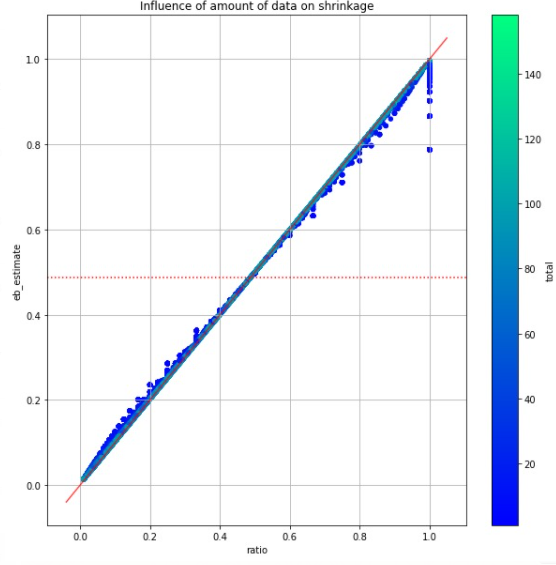
Note that the solid red line shows the observed purchase ratio, meanwhile the dotted red line shows the prior. Thus, dots close to the solid red line show little shrinkage and the color shows the amount of months for every client in history.

In [ ]:
ax = df_posterior.plot.scatter(x='ratio', y='eb_estimate', c='total',
                            colormap='winter', figsize=(10,10), grid=True,
                            sharex=False)
plt.axhline(prior, color='r', linestyle=':')
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])]
plt.plot(lims, lims, 'r-', alpha=.7)
plt.title('Influence of amount of data on shrinkage')

## Stationarity and last month behavior

For the stationarity, I calculated the average standard deviation for each client month to month so we would capture seasonality. On the other hand, last month’s behavior was a simple boolean, “1” if the client made a purchase, “0” if not.

# Modeling

The company wanted an accurate model easy to comprehend. Hence, I decided to use the most popular classification models so it would be easy to try and test. I tested 8 models to get the best one in terms of metrics and then perform a hyperparameter tune if needed.

On the first hand I made a few imports:

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
!pip install xgboost
import xgboost as xgb

Then, I splitted the data

In [ ]:
x, y = df_final.drop(['CodigoUnico','last_month'], axis = 1), df_final.last_month
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .4,
                                                    random_state = 72)

And created a list with the 8 algorithms I was going to try

In [ ]:
models = list()
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('Dtree', DecisionTreeClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GDC', GradientBoostingClassifier()))

Next, I iterated over each tuple's element to extract the alias and the model itself. I used a K-fold cross validation score to compare each one among others and make a decision.

In [ ]:
metrics = dict()
for name, model in models:
    kfold = KFold(n_splits = 2)
    cv_result = cross_val_score(model, x_train, y_train, cv = kfold,
                                scoring = "accuracy")
    metrics[name] = cv_result
dresults = pd.DataFrame(columns = ['Model', 'score'])    
dresults = dresults.append(metrics, ignore_index = True)
dresults.to_excel('model_comparison.xlsx', index = False)

I turned out that best model was the Gradient Boosting Classifier (~ .94). However, linear regression did pretty much good (~ .93) So  I chose Linear Regression mainly because of interpretability (one of the CEO's desires). I fitted and evaluated the model.

In [ ]:
LR = LogisticRegression()
LR.fit(x_train, y_train)

print("Accuracy on training set: {}".format(LR.score(x_train, y_train)))
print("Accuracy on test set: {}".format(LR.score(x_test, y_test)))

y_pred = LR.predict(x_test)
fpr, tpr, thresholds = roc_curve(y, pred, pos_label=2)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(auc(fpr, tpr))

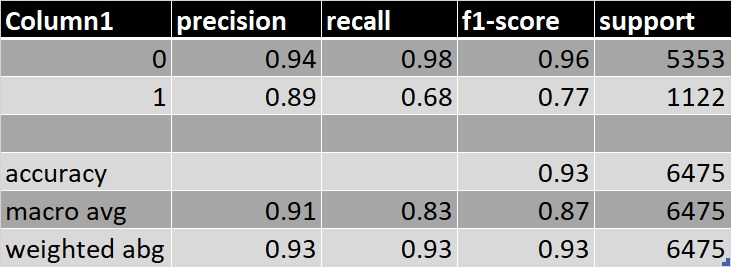
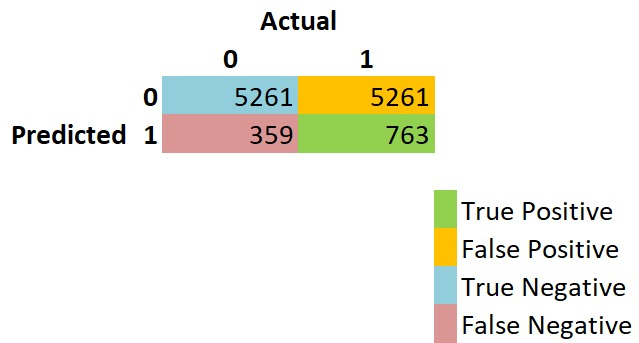

# Final considerations

Even though this project has not been implemented in the company, it might have a huge impact due to scalability. Omnichannality is one of the biggest bets of every industry and predicting when will the next purchase be is a good beginning to be one step ahead during the purchase process. Moreover, knowing which clients will not buy anything leaves the question of should the company focus on these cases rather than those who will.

# References

- *Geron, A. (2019). Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow. OREILY.
- *Karaman, B. (2019, June). Predicting Next Purchase Day. Retrieved from https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027
- *Klaas, J. (2019, January). Taming False Discoveries with Empirical Bayes. Retrieved from https://towardsdatascience.com/taming-false-discoveries-with-empirical-bayes-2ce81aa8f407